![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

In [3]:

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)


,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler
...,...,...,...,...,...,...
399995,29900,2015,25287,TX,Lexus,RXRX
399996,17688,2015,17677,MI,Chevrolet,EquinoxFWD
399997,24907,2014,66688,NC,Buick,EnclaveLeather
399998,11498,2014,37872,IN,Volkswagen,Jetta


In [6]:
# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Year         10495 non-null  int64
 1   Mileage      10495 non-null  int64
 2   M_Camry      10495 non-null  uint8
 3   M_Camry4dr   10495 non-null  uint8
 4   M_CamryBase  10495 non-null  uint8
 5   M_CamryL     10495 non-null  uint8
 6   M_CamryLE    10495 non-null  uint8
 7   M_CamrySE    10495 non-null  uint8
 8   M_CamryXLE   10495 non-null  uint8
 9   HighPrice    10495 non-null  int64
dtypes: int64(3), uint8(7)
memory usage: 657.8 KB


In [7]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [8]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [57]:
X_train.shape[1]

9

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [176]:
# Celda 1
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

tree = tree_grow(X_train, y_train, level=0, min_gain=0.01, max_depth=4, num_pct=8)
tree

{'y_pred': 1,
 'y_prob': 0.5778472913408218,
 'level': 0,
 'split': [0, 2014.0],
 'n_samples': 7031,
 'gain': 0.23411458869944352,
 'sl': {'y_pred': 0,
  'y_prob': 0.08274647887323944,
  'level': 1,
  'split': [1, 47576.44444444444],
  'n_samples': 2270,
  'gain': 0.025814745711531112,
  'sl': {'y_pred': 0,
   'y_prob': 0.403921568627451,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 253,
   'gain': 0.0668189178286328,
   'sl': {'y_pred': 0,
    'y_prob': 0.1044776119402985,
    'level': 3,
    'split': [2, 1.0],
    'n_samples': 65,
    'gain': 0.02053668804800035,
    'sl': {'y_pred': 0,
     'y_prob': 0.05660377358490566,
     'level': 4,
     'split': -1,
     'n_samples': 51,
     'gain': 0.006151480199923107},
    'sr': {'y_pred': 0,
     'y_prob': 0.3125,
     'level': 4,
     'split': -1,
     'n_samples': 14,
     'gain': 0.17006802721088446}},
   'sr': {'y_pred': 1,
    'y_prob': 0.5105263157894737,
    'level': 3,
    'split': [1, 22258.666666666664],
    'n_sample

In [177]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Ejecución de función tree_predict
y_pred = tree_predict(X_test, tree)

In [178]:
from sklearn import metrics

metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.893371757925072, 0.871824480369515)

In [179]:
accuracy_ad = metrics.accuracy_score(y_pred, y_test)

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [53]:
# Celda 2

# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_1 = X_train.iloc[sample]
    y_train_1 = y_train.iloc[sample]
    treereg.fit(X_train_1, y_train_1)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
326011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242354,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
266376,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
396954,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
144298,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
364521,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
120072,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
99878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Votación mayoritaria
y_pred = (y_pred.sum(axis=1) >= (n_B / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
from sklearn import metrics
# Desempeño al hacer votación mayoritaria
metrics.accuracy_score(y_pred, y_test)

0.8533487297921478

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [146]:
# Celda 3

# Definición del modelo BaggingClassifier de la libreria sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, bootstrap=True,#mejor resultado con 550
                        random_state=1, n_jobs=-1, oob_score=False, max_features=int(np.log(X_train.shape[1])))

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.8791666666666667, 0.8493071593533488)

In [147]:
accuracy_bagging = metrics.accuracy_score(y_pred, y_test)

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [148]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier()
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.8665681930083702, 0.8435334872979214)

In [149]:
accuracy_rf_sincalibrar = metrics.accuracy_score(y_pred, y_test)

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [130]:
# Importar librería
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Definir el número de features
n_features = X.shape[1]

# Definir función para graficar el accuracy vs parametro
def plot_Accuracy(param_Range, scores, param_name = "N"):
    plt.plot(param_Range, scores)
    plt.xlabel(param_name)
    vals_dict = {p:v for p,v in zip(param_Range, scores)}
    worst_to_best = sorted(vals_dict, key = lambda x: vals_dict[x])
    print(f"Best {param_name} value = {worst_to_best[-1]}, accuracy = {max(scores)}")

# Definir valores posibles de parámetros
estimators = range(10, 200, 10)
depths = range(2, 20, 1)
features = range(1, n_features+1)

Best n_estimators value = 20, accuracy = 0.8414483087184375


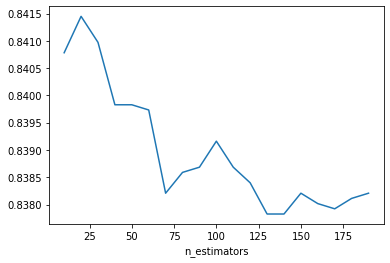

In [131]:
# Estimar el mejor valor de n_estimators
estimators_accuracy_scores = []
for n in estimators:
    clf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
    estimators_accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

plot_Accuracy(estimators, estimators_accuracy_scores, param_name = "n_estimators")

Best max_depth value = 8, accuracy = 0.8855645545497856


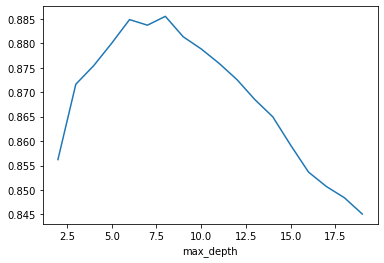

In [132]:
# Estimar el mejor valor de max_depth
depths_accuracy_scores = []
for n in depths:
    clf = RandomForestClassifier(n_estimators=20, max_depth=n, random_state=1, n_jobs=-1)
    depths_accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

plot_Accuracy(depths, depths_accuracy_scores, param_name = "max_depth")

Best max_features value = 3, accuracy = 0.8855645545497856


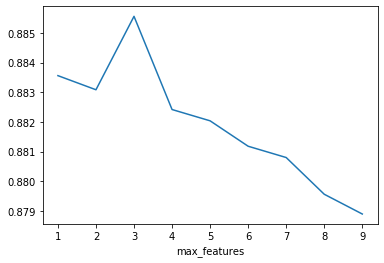

In [133]:
# Estimar el mejor valor de max_features
features_accuracy_scores = []
for n in features:
    clf = RandomForestClassifier(n_estimators=20, max_depth=8, max_features = n, random_state=1, n_jobs=-1)
    features_accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

plot_Accuracy(features, features_accuracy_scores, param_name = "max_features")

In [186]:
from sklearn.metrics import accuracy_score

# Entrenar el modelo con los mejores parámetros
best_rf = RandomForestClassifier(n_estimators=20, max_depth=8, max_features = 3, random_state=1, n_jobs=-1)

# Entrenar el clasificador
best_rf.fit(X_train, y_train)

# Evaluar el clasificador
best_pred = best_rf.predict(X_test)
best_acc = round(accuracy_score(y_test, best_pred), 4)

# Imprimir resultados
print(f"Best params random forest accuracy: {best_acc}")

Best params random forest accuracy: 0.886


In [187]:
accuracy_rf_concalibrar = best_acc

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [151]:
# Celda 6
# Importación y definición de modelo XGBClassifier

from xgboost import XGBClassifier
clf = XGBClassifier()
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

(0.9047160731472569, 0.8856812933025404)

In [152]:
accuracyXGB_sincalibrar = metrics.accuracy_score(y_pred, y_test.values)

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

Best learning_rate value = 0.1, accuracy = 0.8832777513101477


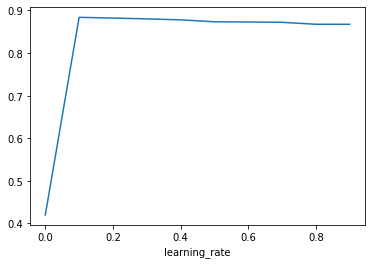

In [136]:
# Celda 7
import warnings
warnings.filterwarnings('ignore')
# Definir valores posibles de parámetros
lrate = np.arange(0, 1, 0.1)
gamma = range(2, 20, 1)
colsample = np.arange(0, 1, 0.1)

lr_accuracy_scores = []
for n in lrate:
    clf = XGBClassifier(learning_rate=n, random_state=1, n_jobs=-1)
    lr_accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

plot_Accuracy(lrate, lr_accuracy_scores, param_name = "learning_rate")

Best gamma value = 9, accuracy = 0.8868032396379227


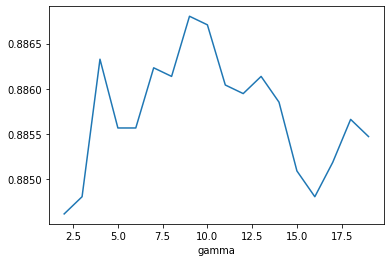

In [137]:
gamma_accuracy_scores = []
for n in gamma:
    clf = XGBClassifier(learning_rate=0.1, gamma = n, random_state=1, n_jobs=-1)
    gamma_accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

plot_Accuracy(gamma, gamma_accuracy_scores, param_name = "gamma")

Best colsample value = 0.4, accuracy = 0.8848975702715579


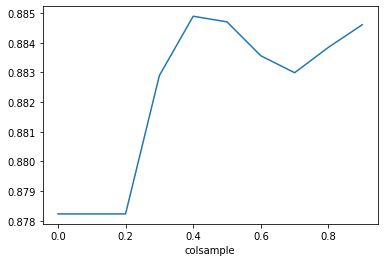

In [138]:
colsample_accuracy_scores = []
for n in colsample:
    clf = XGBClassifier(learning_rate=0.1, gamma = 9, colsample_bytree=n, random_state=1, n_jobs=-1)
    colsample_accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

plot_Accuracy(colsample, colsample_accuracy_scores, param_name = "colsample")

In [153]:
# Entrenar el modelo con los mejores parámetros
best_xgb = XGBClassifier(learning_rate=0.1, gamma = 9, colsample_bytree=0.4, random_state=1, n_jobs=-1)

# Entrenar el clasificador
best_xgb.fit(X_train, y_train)

# Evaluar el clasificador
best_pred = best_xgb.predict(X_test)
best_acc = round(accuracy_score(y_test, best_pred), 4)

# Imprimir resultados
print(f"Best params random forest accuracy: {best_acc}")

Best params random forest accuracy: 0.8871


In [154]:
accuracyXGB_concalibrar = best_acc

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

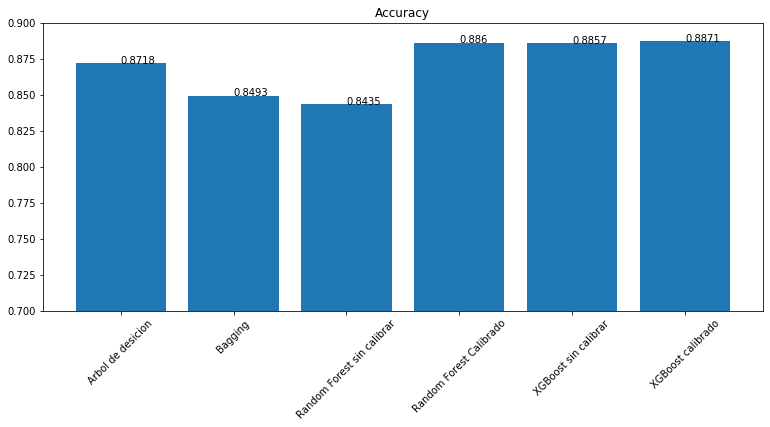

In [188]:
# Celda 8
fig, ax = plt.subplots(figsize = (10, 4))

ax = fig.add_axes([0,0,1,1])
ax.set_title("Accuracy")
ejeX = ['Arbol de desicion', 'Bagging', 'Random Forest sin calibrar', 'Random Forest Calibrado','XGBoost sin calibrar','XGBoost calibrado']
ejeY = [accuracy_ad, accuracy_bagging, accuracy_rf_sincalibrar, accuracy_rf_concalibrar, accuracyXGB_sincalibrar,accuracyXGB_concalibrar]
ejeY = [round(i,4) for i in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.ylim([0.7,0.9])
plt.xticks(rotation=45)
plt.show()


### Conclusiones
* Se puede observar que los modelos que presentan mejor desempeño, son aquellos a los que se les hace un calibracion de hiperparametros
* Para este ejercicio el mejor modelo es XBBoost con calibración seguido muy de cerca de Random Forest con calibración
* El modelo XGBoost presenta un muy buen desempeño tanto con sus hiperparametros por defecto como con el modelo calibrado, debido a su mejoras algoritmicas y optimización de sistemas ya que se ajusta mejor a los errores ya que va iterando sobre estos minimizando la varianza del modelo
* Como se puede observar en la gráfica, random forest sin calibrar hiperparametros y solo con 10 arboles de desicion presenta un bajo desempeño, debido a que le hace falta un mayor numero de árboles para minimizar la varianza y los parametros por defecto no son los apropiados para este ejercicio, lo mismo sucede con el Bagging que presenta un bajo desempeño en comparación con los otros modelos estudiados.
